# DT Decision Node Importance

The DT is a set of Features/Columns/Decision Nodes (Exploitation, Automatable, TechnicalImpact, MissionWellBeing) and a Target/Prediction (Priority).

Each Decision Node has multiple input parameters - from the CVE enrichment data.

## Feature Importance 
In decision trees, every node is a condition of how to split values in a single feature, so that similar values of the dependent variable end up in the same set after the split. The condition is based on impurity, which in case of classification problems is Gini impurity/information gain (entropy), while for regression trees its variance. So when training a tree we can compute how much each feature contributes to decreasing the weighted impurity.
Feature importance: What features have the biggest impact on Priority predictions for
1. DT Decision Nodes
2. DT Decision Nodes input parameters


2 different ways will be used to calculate Feature importance:
1. Permutation Importance 
2. Drop-column Importance

See https://github.com/CERTCC/SSVC/issues/309 for the suggestion to add drop column importance to CISA SSVC.

### Permutation Importance 
A feature is
* “important” if shuffling its values increases the model error because in this case, the model relied on the feature for the prediction.
* “unimportant” if shuffling its values leave the model error unchanged because in this case, the model ignored the feature for the prediction.

### Drop-column Importance
"The idea is to get a baseline performance score as with permutation importance but then drop a column entirely, retrain the model, and recompute the performance score. The importance value of a feature is the difference between the baseline and the score from the model missing that feature. **This strategy answers the question of how important a feature is to overall model performance even more directly than the permutation importance strategy."** https://explained.ai/rf-importance/#5 


## Starting Point
   1. [SEI CMU Prioritizing Vulnerability Response: A Stakeholder-Specific Vulnerability Categorization (Version 2.0)](https://resources.sei.cmu.edu/library/asset-view.cfm?assetid=653459)
      1. "Decision Tree Construction Concerns" 
   2. https://github.com/CERTCC/SSVC/blob/main/src/analyze_csv.py is code to do Permutation Importance on a Decision Tree.

## References
1. https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
2. kaggle.com/code/dansbecker/permutation-importance
3. https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
4. https://pub.towardsai.net/model-explainability-shap-vs-lime-vs-permutation-feature-importance-98484efba066



In [16]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.inspection

# Need these for the plots
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

In [17]:
# read csv
df = pd.read_csv("./DT_rbp.csv")
df

,Leaf,Exploitation,Automatable,TechnicalImpact,MissionWellBeing,Priority
0,1,active,yes,total,high,Act
1,2,active,yes,total,medium,Act
2,3,active,yes,total,low,Attend
3,4,active,yes,partial,high,Act
4,5,active,yes,partial,medium,Attend
5,6,active,yes,partial,low,Attend
6,7,active,no,total,high,Act
7,8,active,no,total,medium,Attend
8,9,active,no,total,low,Track
9,10,active,no,partial,high,Attend


In [18]:
#drop Leaf column as it is does not contribute to priority
df.drop(['Leaf'], axis=1, inplace=True)
df

,Exploitation,Automatable,TechnicalImpact,MissionWellBeing,Priority
0,active,yes,total,high,Act
1,active,yes,total,medium,Act
2,active,yes,total,low,Attend
3,active,yes,partial,high,Act
4,active,yes,partial,medium,Attend
5,active,yes,partial,low,Attend
6,active,no,total,high,Act
7,active,no,total,medium,Attend
8,active,no,total,low,Track
9,active,no,partial,high,Attend


In [19]:
# turn features into ordinals
# this assumes that every column is an ordinal label
# and that the ordinals are sorted in ascending order
# code from https://github.com/CERTCC/SSVC/blob/main/src/analyze_csv.py
encoded = {c: list(enumerate(df[c].unique())) for c in df.columns}
cols = []
for c in df.columns:
    newcol = f"{c}"
    cols.append(newcol)
    codes = list(enumerate(df[c].unique()))
    mapper = {v:k for (k,v) in codes}
    df[newcol] = df[c].replace(mapper)
df2 = df[cols]
    
df2

,Exploitation,Automatable,TechnicalImpact,MissionWellBeing,Priority
0,0,0,0,0,0
1,0,0,0,1,0
2,0,0,0,2,1
3,0,0,1,0,0
4,0,0,1,1,1
5,0,0,1,2,1
6,0,1,0,0,0
7,0,1,0,1,1
8,0,1,0,2,2
9,0,1,1,0,1


In [20]:
# y = f(x)
target = "Priority"

# construct feature list
y = df2[target]
y

0     0
1     0
2     1
3     0
4     1
5     1
6     0
7     1
8     2
9     1
10    2
11    2
12    1
13    3
14    2
15    1
16    2
17    2
18    1
19    3
20    2
21    2
22    2
23    3
24    1
25    2
26    2
27    1
28    2
29    2
30    3
31    2
32    2
33    2
34    2
35    2
Name: Priority, dtype: int64

In [21]:
X = df2.loc[:,df2.columns!=target]
X

,Exploitation,Automatable,TechnicalImpact,MissionWellBeing
0,0,0,0,0
1,0,0,0,1
2,0,0,0,2
3,0,0,1,0
4,0,0,1,1
5,0,0,1,2
6,0,1,0,0
7,0,1,0,1
8,0,1,0,2
9,0,1,1,0


In [22]:
# construct tree
dt = DecisionTreeClassifier(random_state=99,criterion="entropy")
dt.fit(X,y)



DecisionTreeClassifier(criterion='entropy', random_state=99)

In [23]:
# analyze tree
result = sklearn.inspection.permutation_importance(dt,X,y,n_repeats=20,random_state=0)
result

{'importances_mean': array([0.42638889, 0.2375    , 0.20277778, 0.46388889]),
 'importances_std': array([0.07096937, 0.05157624, 0.05964142, 0.08291562]),
 'importances': array([[0.38888889, 0.41666667, 0.33333333, 0.33333333, 0.30555556,
         0.5       , 0.47222222, 0.38888889, 0.41666667, 0.41666667,
         0.55555556, 0.36111111, 0.47222222, 0.52777778, 0.41666667,
         0.44444444, 0.52777778, 0.5       , 0.41666667, 0.33333333],
        [0.25      , 0.25      , 0.25      , 0.19444444, 0.19444444,
         0.27777778, 0.33333333, 0.16666667, 0.22222222, 0.16666667,
         0.25      , 0.33333333, 0.22222222, 0.19444444, 0.25      ,
         0.25      , 0.25      , 0.19444444, 0.33333333, 0.16666667],
        [0.27777778, 0.22222222, 0.08333333, 0.30555556, 0.25      ,
         0.16666667, 0.19444444, 0.30555556, 0.22222222, 0.27777778,
         0.13888889, 0.13888889, 0.22222222, 0.19444444, 0.16666667,
         0.13888889, 0.22222222, 0.13888889, 0.16666667, 0.22222222],

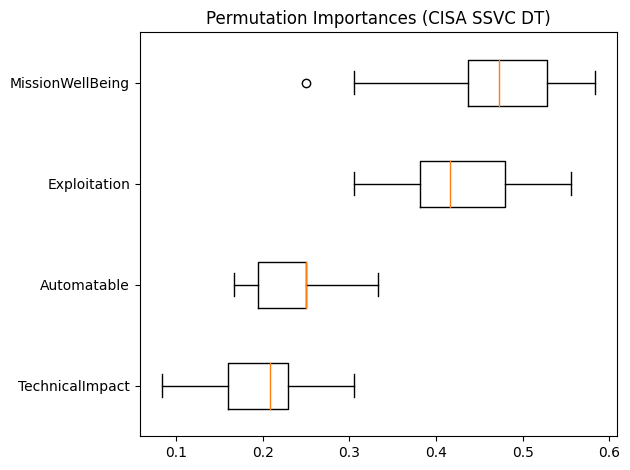

In [24]:
sorted_idx = result.importances_mean.argsort()
        
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False,
           labels=X.columns[sorted_idx])

ax.set_title("Permutation Importances (CISA SSVC DT)")
fig.tight_layout()
plt.show()

# Drop Column

In [25]:
# code from https://gist.github.com/erykml/6854134220276b1a50862aa486a44192#file-drop_col_feat_imp-py
from sklearn.base import clone 

def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names, 'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [26]:
result = drop_col_feat_imp(dt,X,y, 42)
result = result.sort_values(by=['feature_importance'], ascending=True)

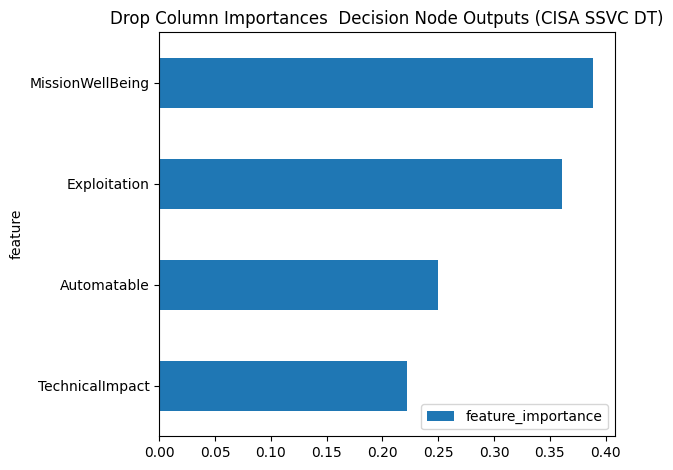

In [27]:
ax = result.plot.barh(x='feature', y='feature_importance')
ax.set_title("Drop Column Importances  Decision Node Outputs (CISA SSVC DT)")
ax.figure.tight_layout()
